In [661]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from decimal import Decimal
from scipy import stats

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, balanced_accuracy_score,\
    roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

прочтем датасет с красным  и белым вином и объединими их. В качестве переменной добавим тип вина

In [311]:
#red_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', delimiter=';')
#white_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', delimiter=';')
red_wine = pd.read_csv('data/winequality-red.csv', delimiter=';')
white_wine = pd.read_csv('data/winequality-white.csv', delimiter=';')

red_wine['type'] = 0
white_wine['type'] = 1
df = pd.concat([red_wine, white_wine], ignore_index=True)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


# Exploratorary data analysis (EDA)

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB
None


Сначала проверим пропущенные значение, как можно заметить их нету. Поэтому импутация не требуется

In [4]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64

Посмотрим на представленность вин по качеству. На распределении, стратифицированному по типу вин, можно увидеть схожесть распределения. Вины самого худшего и самого лучшего качестве плохо представлены, что может затем повлиять на обучение при разбиении данных. Учтем это позже

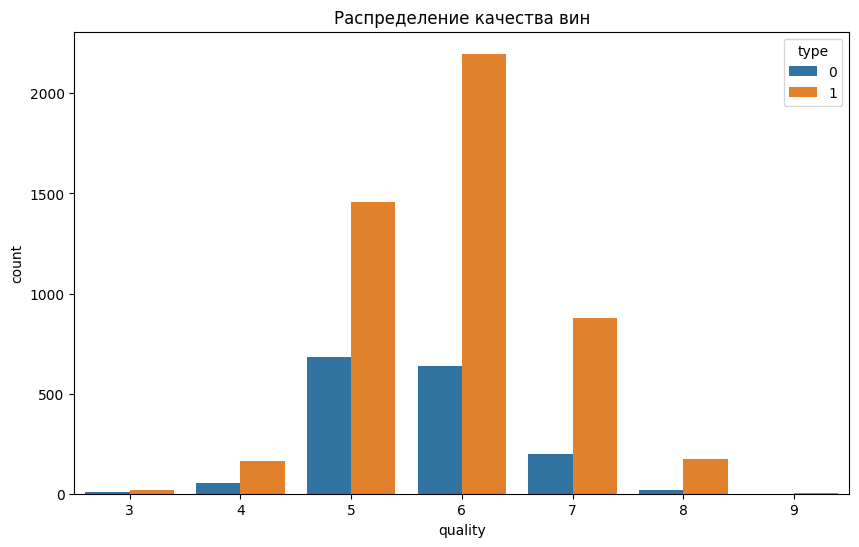

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(x='quality', data=df, hue='type')
plt.title('Распределение качества вин')
plt.savefig('quality_distribution.png')
plt.show()

In [85]:
df.quality.value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

Проведем насколько вариабельны данные и вцелом сравнить описательную статистику. Можно увидеть, что density не имеет практически никакой вариабельности, так как std ~ 0. Проверим позже, насколько полезна эта фича для предсказания качества вина, так как возможно она не будет полезна из-за низкой вариабельности

In [6]:
desc_stats = dict()

for col in df.columns:
    if (df[col].dtype != float):
        continue
    
    def round_desc_stat(val) :
        return float(Decimal(val).quantize(Decimal('1.00')))

    ci_mean_low, ci_mean_high = stats.t.interval(0.95, 
                                                 df=df[col].shape[0] - 1,
                                                 loc=df[col].mean(), 
                                                 scale=stats.sem(df[col]))
    mean_val = df[col].mean()
    std_val = np.std(df[col], ddof=1)
    min_val = df[col].min()
    max_val = df[col].max()

    q1     = np.quantile(df[col], 0.25)
    median = np.quantile(df[col], 0.50)
    q3     = np.quantile(df[col], 0.75)

    ci_mean_low  = round_desc_stat(ci_mean_low)
    ci_mean_high = round_desc_stat(ci_mean_high)
    mean_val     = round_desc_stat(mean_val)
    q1     = round_desc_stat(q1)
    median = round_desc_stat(median)
    q3     = round_desc_stat(q3)
    std_val = round_desc_stat(std_val)
    min_val = round_desc_stat(min_val)
    max_val = round_desc_stat(max_val)
    

    desc_stats[col] = [f'{mean_val} [{ci_mean_low}, {ci_mean_high}]', 
                       f'{median} [{q1}, {q3}]',
                       f'{std_val}',
                       f'{min_val}',
                       f'{max_val}']

desc_stats = pd.DataFrame(desc_stats, 
                          index=('Mean (CI)',
                                 'Median (Q1, Q3)',
                                 'std',
                                 'Min',
                                 'Max'))
desc_stats.T

,Mean (CI),"Median (Q1, Q3)",std,Min,Max
fixed acidity,"7.22 [7.18, 7.25]","7.0 [6.4, 7.7]",1.3,3.8,15.9
volatile acidity,"0.34 [0.34, 0.34]","0.29 [0.23, 0.4]",0.16,0.08,1.58
citric acid,"0.32 [0.32, 0.32]","0.31 [0.25, 0.39]",0.15,0.0,1.66
residual sugar,"5.44 [5.33, 5.56]","3.0 [1.8, 8.1]",4.76,0.6,65.8
chlorides,"0.06 [0.06, 0.06]","0.05 [0.04, 0.07]",0.04,0.01,0.61
free sulfur dioxide,"30.53 [30.09, 30.96]","29.0 [17.0, 41.0]",17.75,1.0,289.0
total sulfur dioxide,"115.74 [114.37, 117.12]","118.0 [77.0, 156.0]",56.52,6.0,440.0
density,"0.99 [0.99, 0.99]","0.99 [0.99, 1.0]",0.0,0.99,1.04
pH,"3.22 [3.21, 3.22]","3.21 [3.11, 3.32]",0.16,2.72,4.01
sulphates,"0.53 [0.53, 0.53]","0.51 [0.43, 0.6]",0.15,0.22,2.0


Видно, что density не несет никакой изменчивости (std~0), поэтому может ее удалить. Также стоит отметить, что в total sulfur dioxide уже содержится свободный, поэтому можно получить связанный диоксид и отбросить общий, так как тут происходит дублированние информация, что может уменьшить интепретируемость финальной модели и ухудшить метрики модели

In [312]:
df['bound sulfur dioxide'] = df['total sulfur dioxide'] - df['free sulfur dioxide']
df = df.drop(columns=['total sulfur dioxide'], axis=1)
#df = df.drop(columns=['total sulfur dioxide', 'density'], axis=1)

Построим распределение для каждой непрерывной переменной. Можно заметить, что большинство распределение имеют малое количество данных в хвосте, скорее всего это выбросы, с ними мы будем разбираться позже. Стоит отметить, что большинство распределение нормальные, за исключением residual sugar, которое больше похоже на экспоненциальное. Более того, ковариаты диоксида и хлорида как-будто бы имеют бимодальное распределение

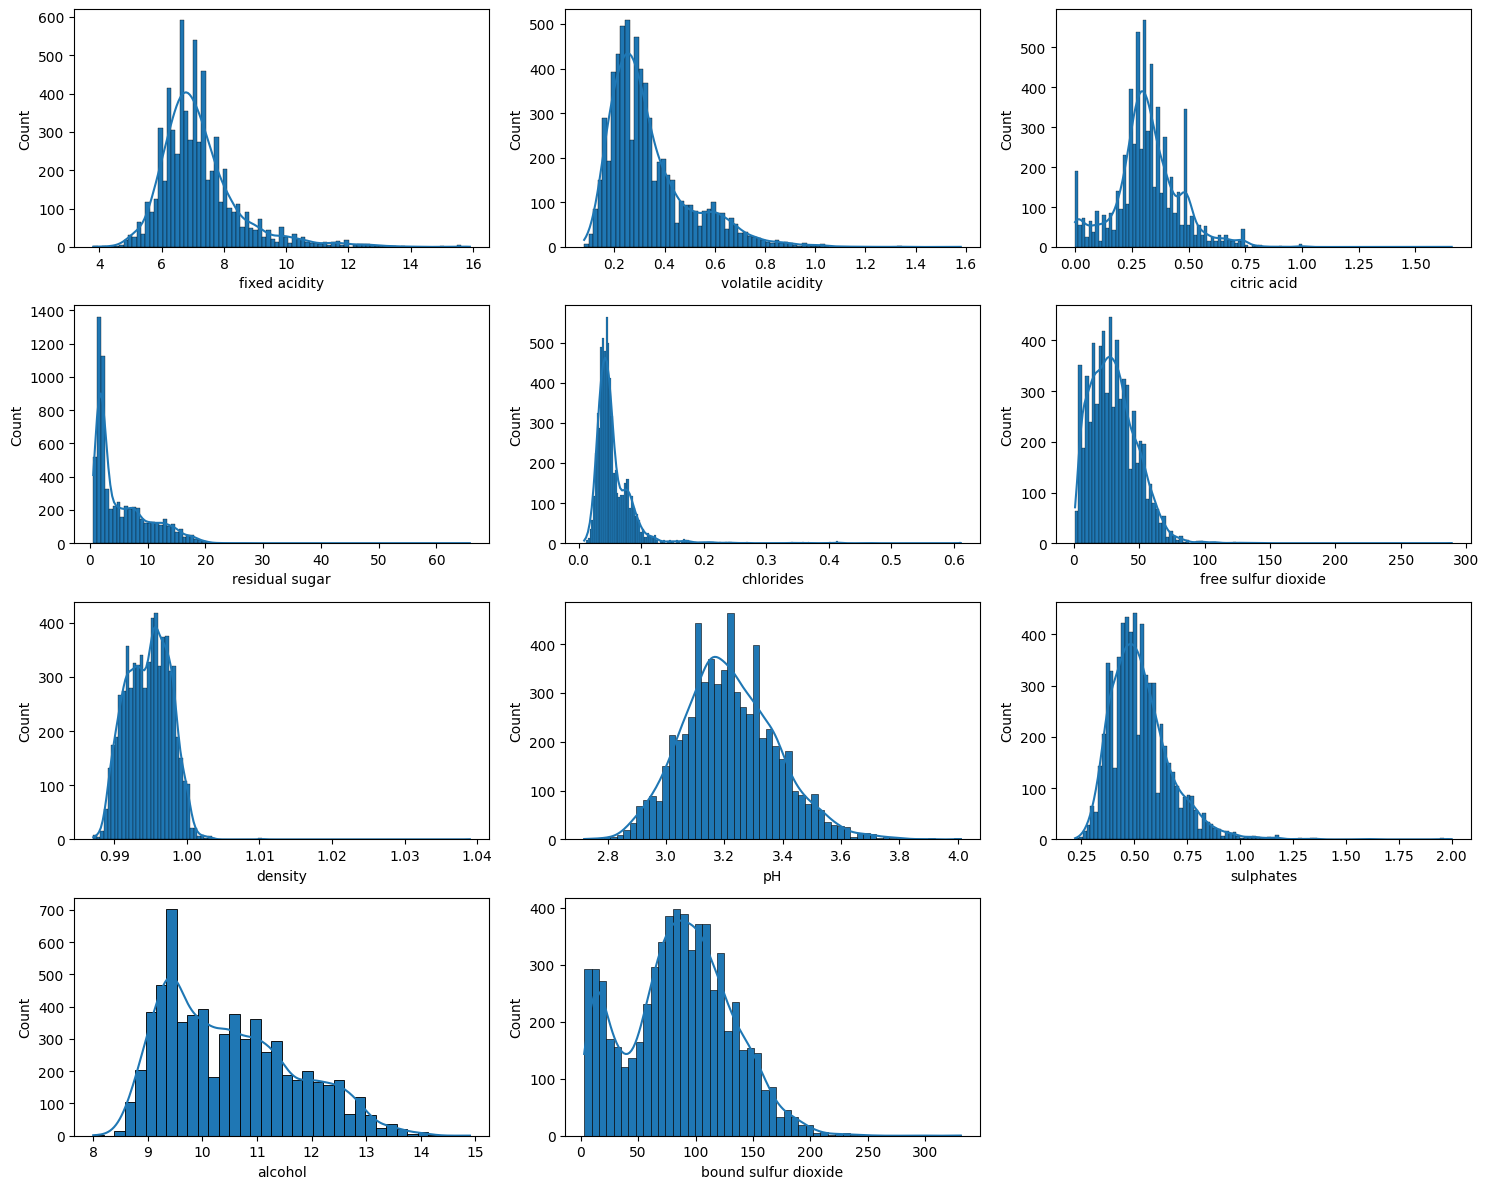

In [313]:
plt.figure(figsize=(15, 12))
for i, column in enumerate(df.drop(columns=['quality', 'type'])): 
    plt.subplot(4, 3, i+1)
    sns.histplot(df[column], kde=True, alpha=1)
plt.tight_layout()
plt.savefig('feature_distributions.png')
plt.show()

Стратифцируем вина по их типу (красные и белые), чтобы посмотреть на бимодальные распределения. Мы видим, что большинство распределний, вцелом разделяются по типу вина, поэтому стоит обрабатывать выбросы, учитывая тип вина. Мы будем использовать ковариату типа вина для корректировки предсказания будущей модели, но возможно на этом этапе лучше было создать один пайплайн и построить две разные модели для разных типов вина. Следовательно фильтровать выбросы, если они есть, лучше, учитывая данные факт

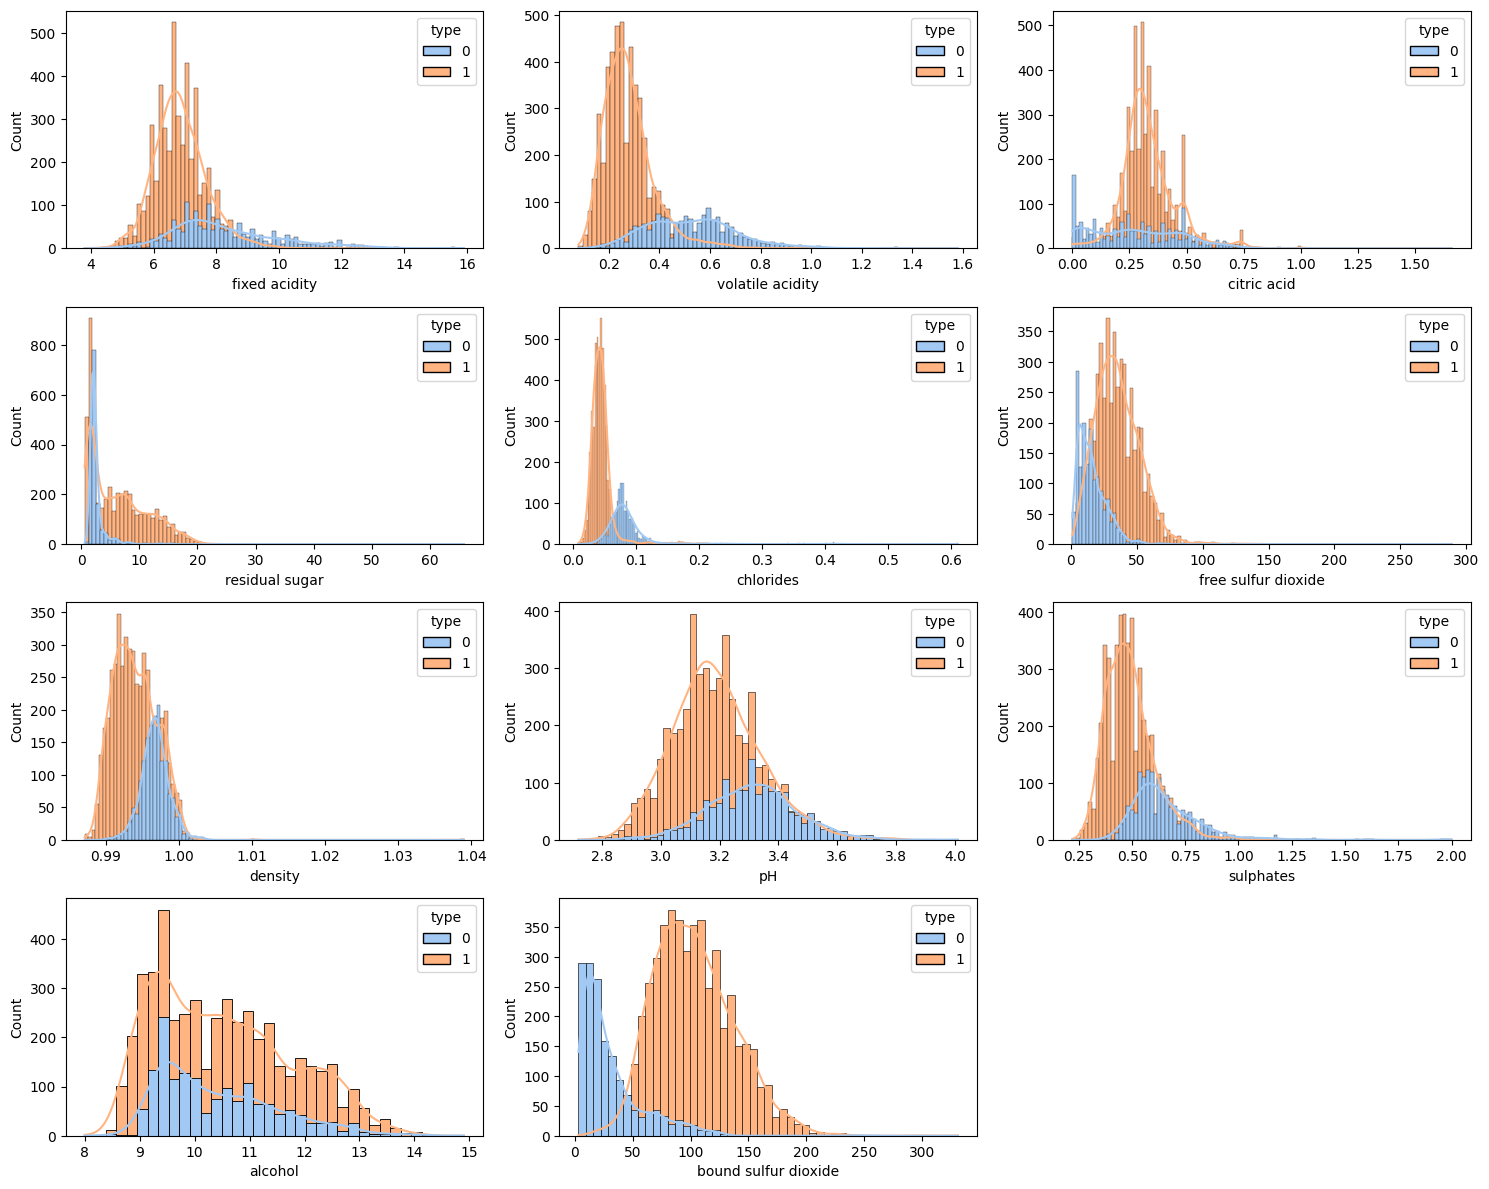

In [314]:
plt.figure(figsize=(15, 12))
for i, column in enumerate(df.drop(columns=['quality', 'type'])): 
    plt.subplot(4, 3, i+1)
    sns.histplot(df[[column, 'type']], x=column, kde=True, hue='type', palette="pastel", alpha=1)
plt.tight_layout()
#plt.savefig('figures/feature_dist_type_strat.png')
plt.show()

## Outliers

Так как не все данные у нас распределены нормально, то применю метод межквартильных размахов, чтобы увидеть количество выбросов. Т.е. будем считать выбросами точки, находящиеся на концах распределения (примерно 2.5 и 97.5 пернцетили)

In [257]:
def plot_grouped_boxplots(df, n_cols=3):
    groups = {}
    for col in df.drop(columns=['type', 'quality']).columns:
        max_val = df[col].max()
        scale = 10 ** (len(str(int(max_val))) - 1) if max_val > 0 else 0
        group_key = f"{scale}-{scale*10}"
        groups.setdefault(group_key, []).append(col)
    
    n_groups = len(groups)
    n_rows = (n_groups + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    
    for (key, cols), ax in zip(groups.items(), axes.flatten()):
        sns.boxplot(data=df[cols + ['type']].melt(id_vars='type'),
                    x='variable',
                    y='value',
                    ax=ax, 
                    hue='type')
        ax.tick_params(axis='x', rotation=90)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, title='type', loc='upper center', bbox_to_anchor=(0.5, 0.1))

    for ax in axes.flatten():
        ax.get_legend().remove()

    plt.tight_layout()

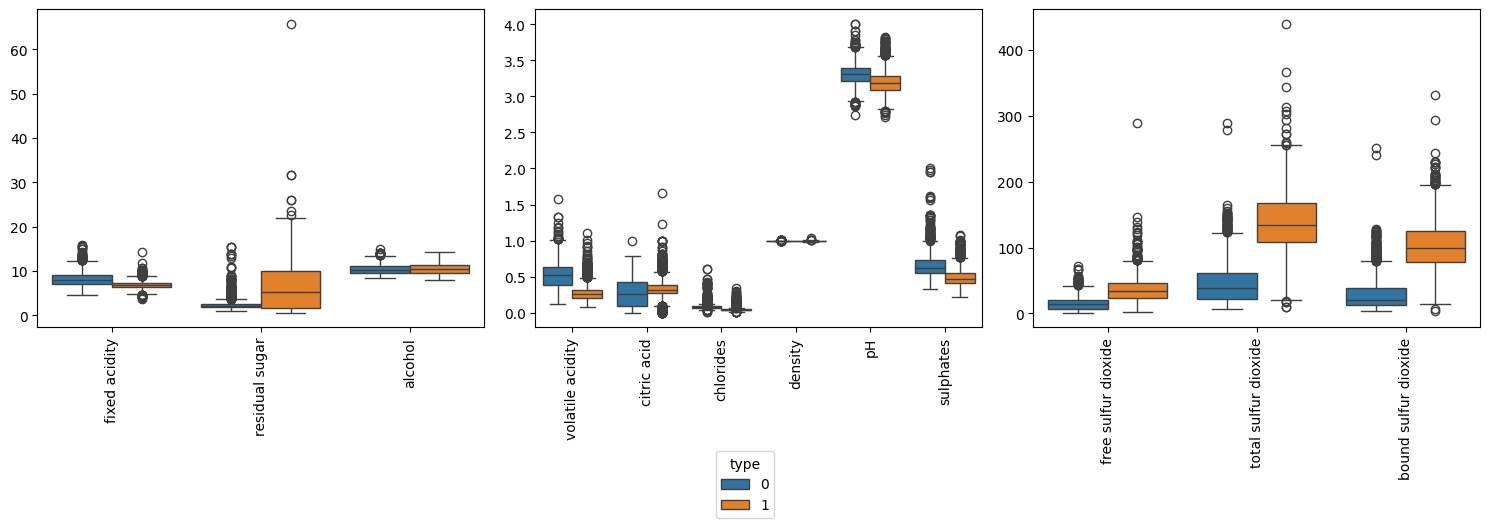

In [258]:
plot_grouped_boxplots(df)

посчитаем процент выбросов по каждому датасету

In [259]:
def calculate_outliers(df):
    outliers_percent = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_percent[col] = (len(outliers) / len(df)) * 100
        outliers_percent[col] = Decimal(Decimal(outliers_percent[col])).quantize(Decimal('1.00'),
                                                                                  rounding='ROUND_HALF_UP')
    return outliers_percent

outliers_percent_all   = calculate_outliers(df.drop(columns=['type','quality']))
outliers_percent_red   = calculate_outliers(df.loc[df['type'] == 0].drop(columns=['type','quality']))
outliers_percent_white = calculate_outliers(df.loc[df['type'] == 1].drop(columns=['type','quality']))
for key, _ in outliers_percent_all.items():
    outliers_percent_all[key] = [outliers_percent_all[key],
    outliers_percent_red[key],
    outliers_percent_white[key]]
outliers_percent_all = pd.DataFrame(outliers_percent_all)
outliers_percent_all.index = ['All', 'Red', 'White']
outliers_percent_all

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,bound sulfur dioxide
All,5.49,5.80,7.83,1.82,4.40,0.95,0.15,0.05,1.12,2.94,0.05,0.31
Red,3.06,1.19,0.06,9.69,7.00,1.88,3.44,2.81,2.19,3.69,0.81,7.25
White,2.43,3.80,5.51,0.14,4.25,1.02,0.39,0.10,1.53,2.53,0.00,0.88


В отличии от задач, где выбросы могут представлять собой интересующие нас точки (например, мошенничество, если точка выбивается из распределения, скорее всего это будет пользователь/бот, с "необычними действиями", в том числе спам). Тут же у нас неизвестно какие точки точно будут являться вполне закономернными выбросами, а какие техническим артефактом. 

Я применю isolation forest, по следующим причинам 
<ul>
<li>Для него нам не требуется удолетворять условия по конкретному типу распределения</li>
<li>У нас не так много фич (всего 11, и 1 категориальная и того 10)</li>
<li>Учитывает взаимодействия между признаками</li>
</ul>

Можно было бы подобрать параметры IsolationForest, мы в данной работе опустим этот момент

In [12]:
def handle_outliers(df, outliers_percent):
    iso_forest = IsolationForest(contamination='auto', random_state=42)
    outliers_mask = iso_forest.fit_predict(df) == -1
    print(f"Удалено строк: {outliers_mask.sum()} ({outliers_mask.mean()*100:.2f}%)")
    return df[~outliers_mask]
        

In [340]:
df_rw_filtered = handle_outliers(df.loc[df['type'] == 0], outliers_percent_all.loc['All', :])
df_ww_filtered = handle_outliers(df.loc[df['type'] == 1], outliers_percent_all.loc['All', :])

df_final = pd.concat([df_rw_filtered, df_ww_filtered])
df_final.shape

Удалено строк: 131 (8.19%)
Удалено строк: 320 (6.53%)


(6046, 13)

Посмотрим снова на распределения и увидим, что пропали точки с хвостов, что сильно "растягивали" наши распределения, при этом сами распределения, примерно, сохранили свою форму.

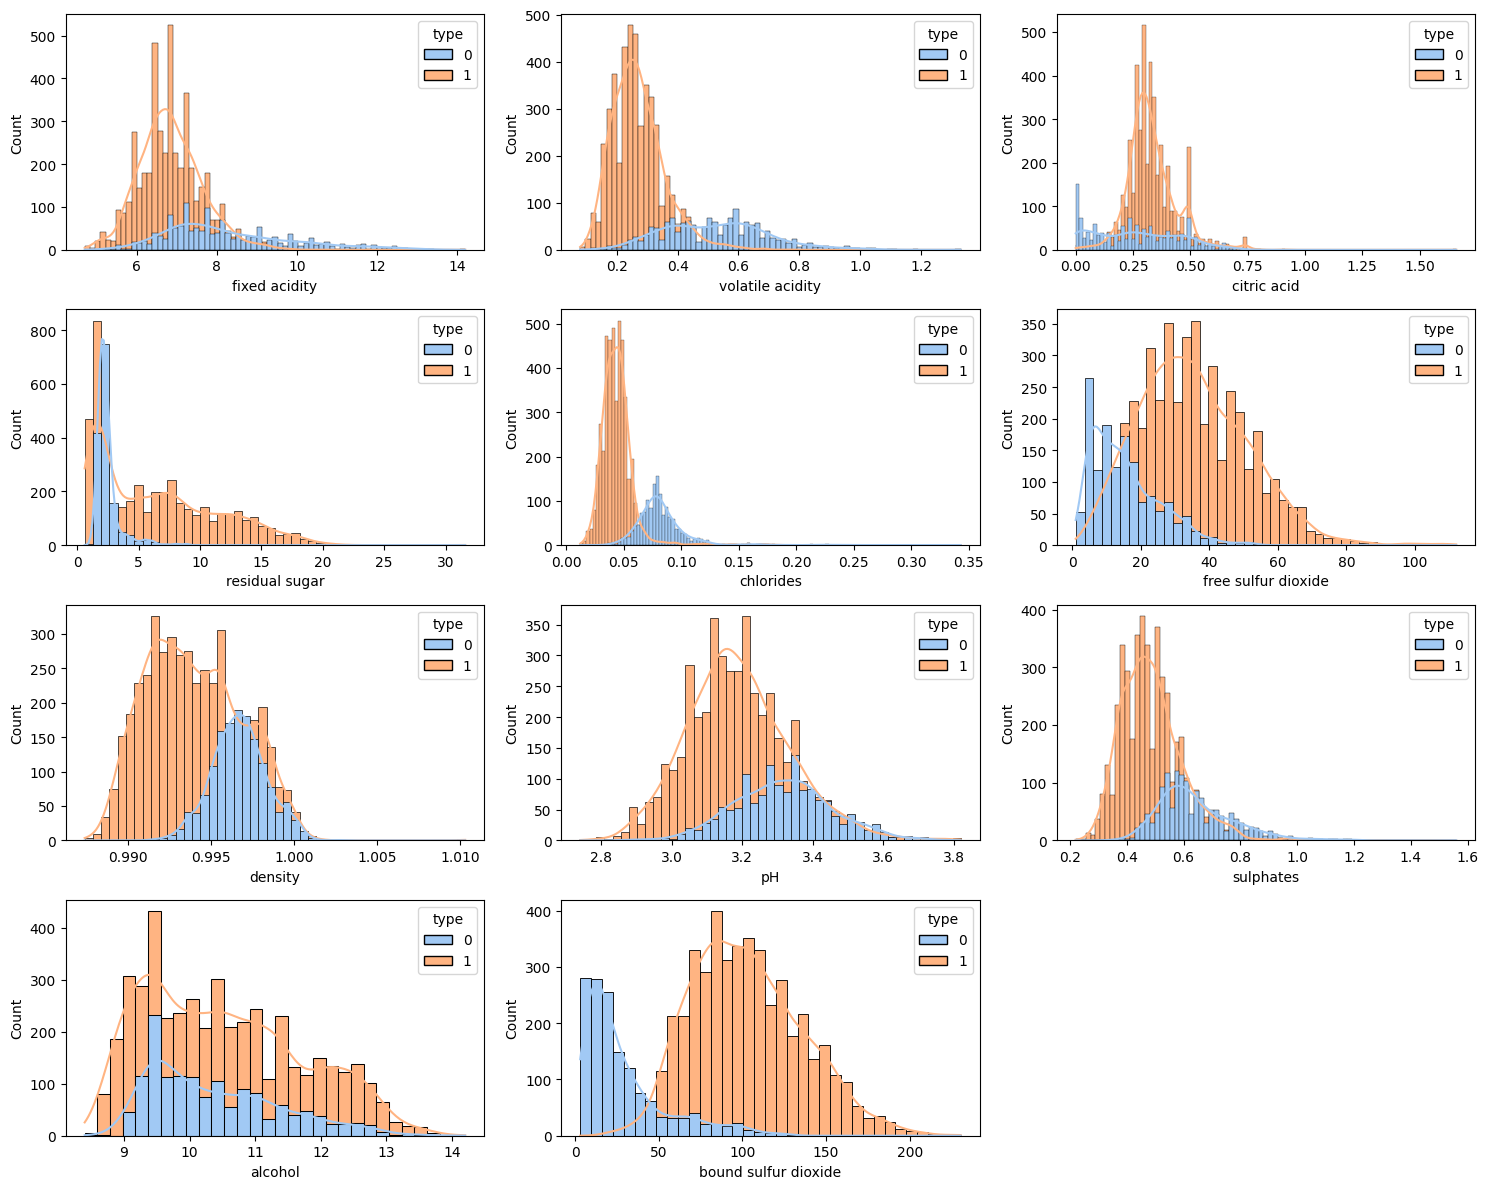

In [372]:
plt.figure(figsize=(15, 12))
for i, column in enumerate(df_final.drop(columns=['quality', 'type'])): 
    plt.subplot(4, 3, i+1)
    sns.histplot(df_final[[column, 'type']], x=column, kde=True, hue='type', palette="pastel", alpha=1)
plt.tight_layout()
#plt.savefig('figures/feature_dist_type_strat.png')
plt.show()

Можно заметить по боксплотам, что пропали явные выбросы в диоксидах (были значения близко к 300), а также в residual sugar. Выбросы по IQR*1.5 стали не такими изоллированами

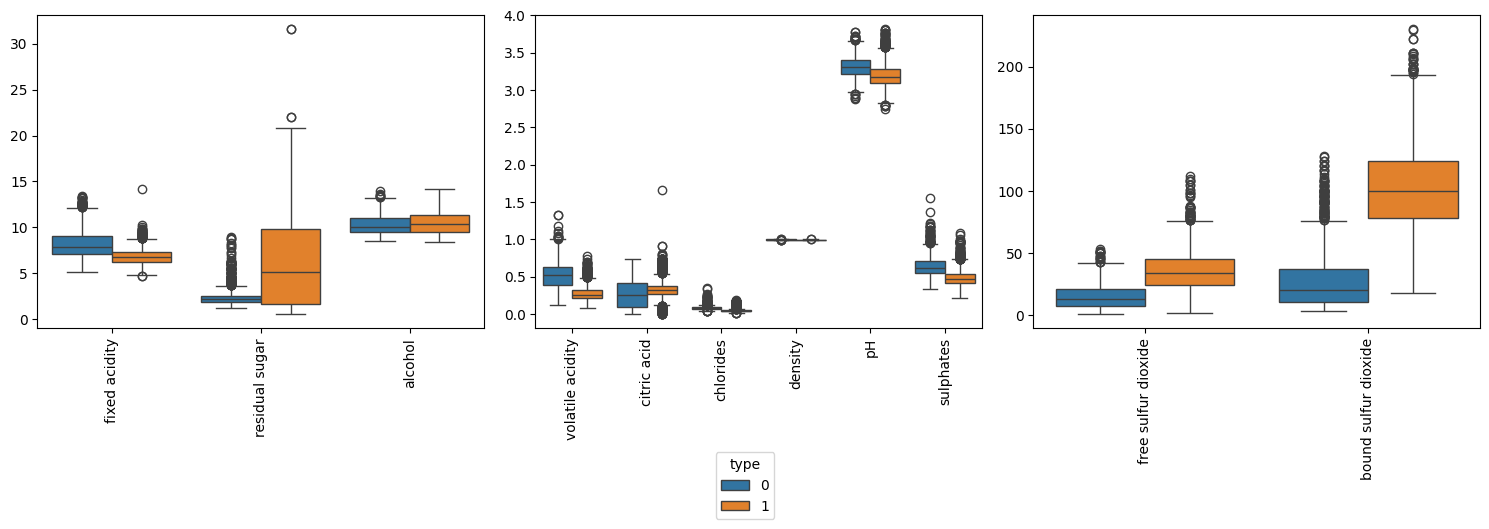

In [373]:
plot_grouped_boxplots(df_final)

Заметим, что сохранилось и распределение таргетовой переменной (качество вина)

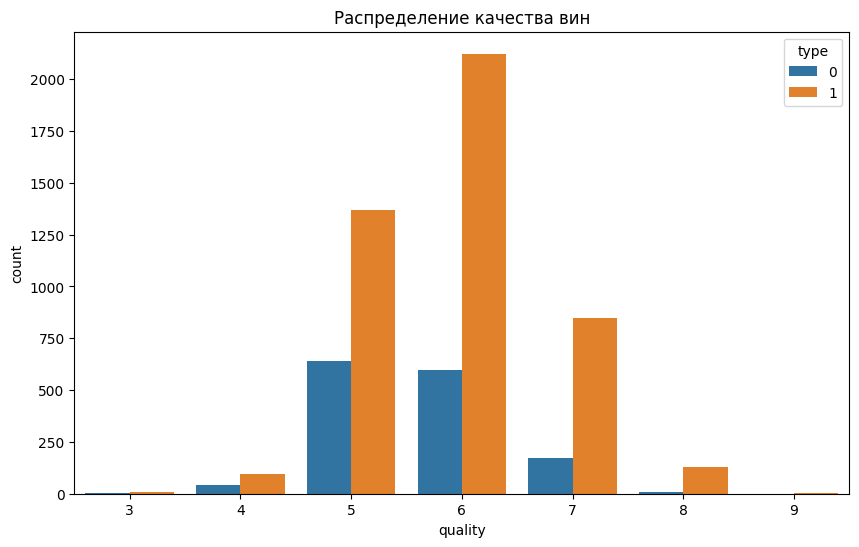

In [318]:
plt.figure(figsize=(10, 6))
sns.countplot(x='quality', data=df_final, hue='type')
plt.title('Распределение качества вин')
plt.savefig('quality_distribution.png')
plt.show()

# Data preparation for training

Так как заметно, что у нас существует дисбаланс по качеству вина, то предсказания модели, могут быть смещены в сторону 5 и 6. Можно применить oversampling и undersampling, чтобы количество вин в категориях качества было примерно равным, но тут видно, что для некоторых классов количество вин настолько мало, что не позволит адекватно применить данный метод. Я выделю три класса (хуже среднего, среднее и лучше среднего). Можно будет в дальнейшем добавить вспомогательные модели, которые уточняют оценку внутри каждой из категорий

In [341]:
#0 - lower average
#1 - average
#2 - above average

df_final.loc[df_final['quality'].isin([8, 9]), 'quality'] = 7
df_final.loc[df_final['quality'].isin([3, 4]), 'quality'] = 5
df_final['quality'] -= 5

Теперь дисбаланс классов не такой существенный

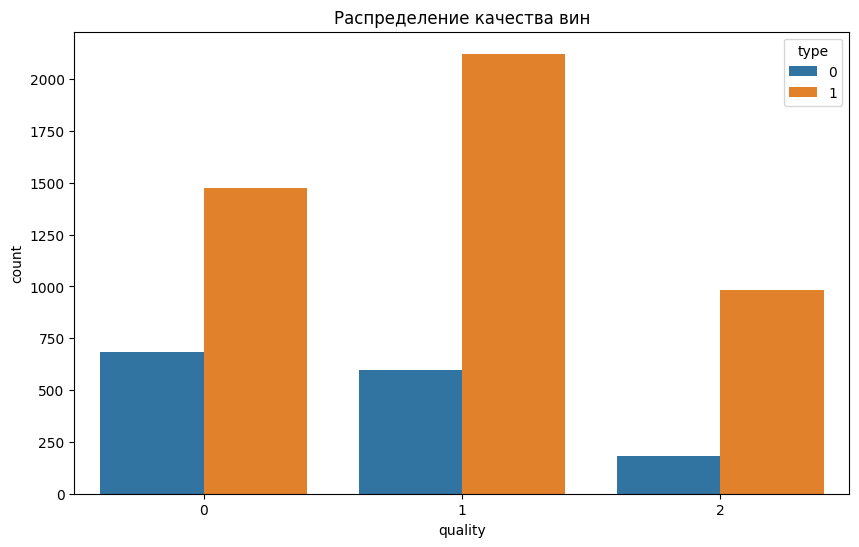

In [428]:
plt.figure(figsize=(10, 6))
sns.countplot(x='quality', data=df_final, hue='type')
plt.title('Распределение качества вин')
plt.savefig('quality_distribution.png')
plt.show()

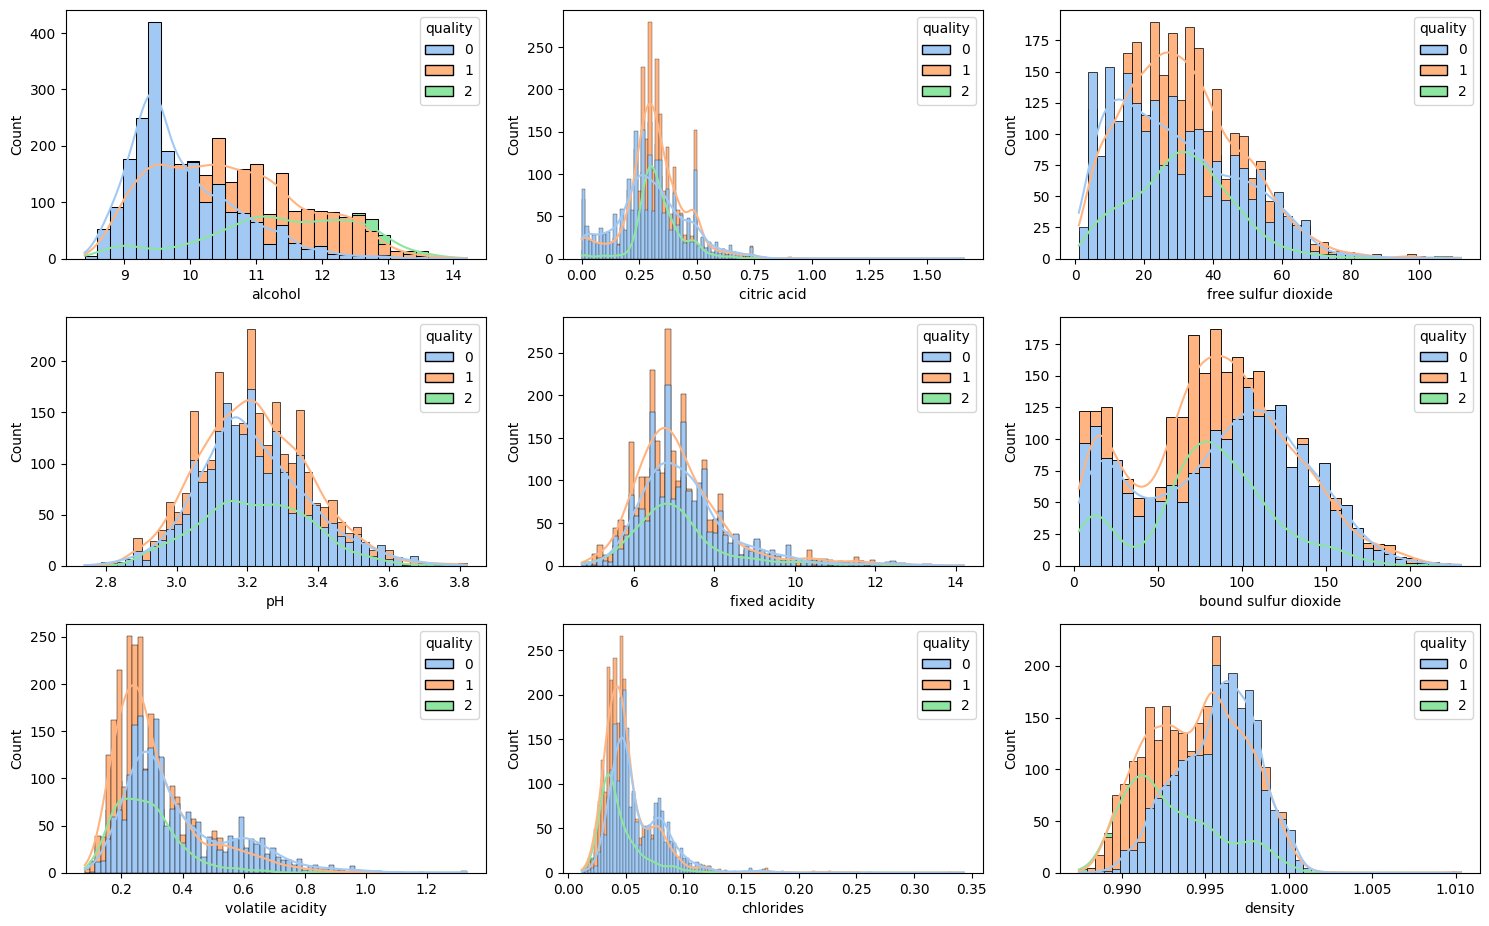

In [652]:
plt.figure(figsize=(15, 12))
for i, column in enumerate(df_final.drop(columns=['quality', 'type'])): 
    plt.subplot(4, 3, i+1)
    sns.histplot(df_final[[column, 'quality']], x=column, kde=True, hue='quality', palette="pastel", alpha=1)
plt.tight_layout()
#plt.savefig('figures/feature_dist_type_strat.png')
plt.show()

Выберем какой-то набор ассоциированных переменных с качеством вина. Видно, что density оказалось на самом деле полезной ковариатой

In [392]:
corr_values = df_final.drop(columns='type').corr(method='spearman')['quality'].sort_values(ascending=False)
corr_values

quality                 1.000000
alcohol                 0.456512
citric acid             0.111957
free sulfur dioxide     0.074552
pH                      0.019714
sulphates               0.019467
residual sugar         -0.028530
fixed acidity          -0.085792
bound sulfur dioxide   -0.095249
volatile acidity       -0.250700
chlorides              -0.298744
density                -0.332507
Name: quality, dtype: float64

In [393]:
top    = corr_values[1:5].index.to_list()
bottom = corr_values[-5:].index.to_list()

top_features = top + bottom
top_features

['alcohol',
 'citric acid',
 'free sulfur dioxide',
 'pH',
 'fixed acidity',
 'bound sulfur dioxide',
 'volatile acidity',
 'chlorides',
 'density']

In [395]:
df_final = df_final[['quality', 'type'] + top_features]

In [212]:
def prepare_data_for_train(df):
    categorical_features = ['type'] 
    numeric_features = [col for col in df.columns if col not in ['type', 'quality']]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)  
        ])

    X = df.drop('quality', axis=1)
    y = df['quality']

    X_processed = preprocessor.fit_transform(X)

    print("Пример первых 5 строк:\n", X_processed[:5].toarray() if hasattr(X_processed, 'toarray') else X_processed[:5])

    return (X_processed, y)

# Training

Разделим на тренировочную и тестовую выборку, при этом сохранив пропорцию классов в обеих выборках. Предварительн данные будут стандартизированы StandardScaler()

In [396]:
X_processed, y = prepare_data_for_train(df_final)

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nРазмеры выборок: X_train={X_train.shape}, X_test={X_test.shape}")

Пример первых 5 строк:
 [[-0.93941606 -2.32593311 -1.14625046  1.87466285  0.1723262  -1.383893
   2.33113843  0.92664162  1.10696087  0.        ]
 [-0.59150994 -2.32593311 -0.316822   -0.12840742  0.50391205 -0.95819665
   3.47289225  1.83085665  0.75520414  0.        ]
 [-0.59150994 -2.03021474 -0.9092709   0.2592836   0.50391205 -1.02541186
   2.71172304  1.58425255  0.82555548  0.        ]
 [-0.59150994  1.81412414 -0.79078112 -0.3868681   3.32239177 -0.93579158
  -0.33295383  0.88554094  1.17731222  0.        ]
 [-0.93941606 -2.32593311 -1.14625046  1.87466285  0.1723262  -1.383893
   2.33113843  0.92664162  1.10696087  0.        ]]

Размеры выборок: X_train=(4232, 10), X_test=(1814, 10)


## Custom FFNN with weights on classes for balancing

По заданию нужно использовать только библиотеки scikit-learn, pandas, numpy, поэтому остается использовать MLPRegressor/MLPClassifier. Мне показалось, что надо сделать "с нуля", так как в ТЗ необходимо описать градиентный спуск

Я реализовал простейшую FFNN, где есть один скрытый слой и настраиваемое количество нейронов. В качестве выходной слоя будет один нейрон, это непрерывное значение, которое будет сохраняться в диапозоне от 0 до 2 (как наши ранги). Сама работа нейронной сети состоит из нескольких шагов:
Вначале мы инициализируем веса для наших нейронов случайными значениями (w1, w2 для входного и скрытого соотвественно). <br>

Далее происходит fit, где эпохи это своего рода итерации
<ol>
<li>Нормализуем веса для наших рангов (у нас есть небольшой дисбаланс по классам)
<li> Выделяем батч (отделяем кусок данных) и подаем его в прямую пропогацию
<li> в Прямой пропогации происходит умножение значения входных данных с весами и прибавление свободных членов (b). Затем все подается в функцию активации  
<li>Далее вычисляем ошибку на батче (вцелом тут можно внедрить алгоритм, что если n итераций у нас сохраняется маленькая ошибка, то сделаем ранюю остановку)
<li>Обратная пропогация - с помощью градиента от loss функции и функции активации, высчитываем смещение для наших весов. Передаем их в обратную сторону по всем слоям
</ol>
На обратном распространении: 
<ul>
<li> error_sign = np.sign(y_pred - y) - определяет направление ошибки
<li> dL_dz2 - градиент на выходном слое (учитывает веса образцов)
<li> dL_dW2 = self.a1_.T @ dL_dz2 - как изменятся ошибка при изменении весов W2
<li> dL_db2 = np.sum(dL_dz2, axis=0) - как изменятся ошибка при изменении смещения b2
<li> Затем распространяем ошибку назад к скрытому слою
</ul>






В качестве функции активации использовал relu, так как он обнуляет отрицательные значения, при этом положительные оставляет как есть. А также в качестве альтернативы взял сигмоиду, из-за гладкости функции

In [568]:
def _sigmoid(x):
    return 1 / (1 + np.exp(-x))

def _sigmoid_derivative(x):
    return x * (1 - x)

def _relu(x):
    return np.maximum(0, x)

def _relu_derivative(x):
    return (x > 0).astype(float)

MIN_CLASS = 0
MAX_CLASS = 2

class WeightedFFNN(BaseEstimator, RegressorMixin):
    def __init__(self, 
                 hidden_size=32, 
                 learning_rate=0.01, 
                 epochs=100, 
                 batch_size=32,
                 activation='sigmoid',
                 loss='mae',
                 delta=None,
                 sample_weights=None,
                 random_state=None,
                 verbose=0):
        self.hidden_size    = hidden_size
        self.learning_rate  = learning_rate
        self.epochs         = epochs
        self.batch_size     = batch_size
        self.random_state   = random_state
        self.activation     = activation
        self.sample_weights = sample_weights
        self.verbose        = verbose
        self.loss           = loss
        self.delta          = delta

    def _init_weights(self, n_features):
        np.random.seed(self.random_state)
        self.W1_ = np.random.randn(n_features, self.hidden_size) * 0.01
        self.b1_ = np.zeros(self.hidden_size)
        self.W2_ = np.random.randn(self.hidden_size, 1) * 0.01
        self.b2_ = np.zeros(1)
    
    def _forward(self, X):
        self.z1_ = X @ self.W1_ + self.b1_
        self.a1_ = self.activation_func(self.z1_)
        self.z2_ = self.a1_ @ self.W2_ + self.b2_
        return self.z2_


    def _backward(self, X, y, y_pred, sample_weight):
        m = X.shape[0]
        total_weight = np.sum(sample_weight)
        
        if self.loss == 'huber':
            d = y_pred - y
            delta = self.delta
            huber_grad = np.where(np.abs(d) <= delta, d, delta * np.sign(d))
            dL_dz2 = huber_grad * sample_weight.reshape(-1, 1) / total_weight
        else :
            error_sign = np.sign(y_pred - y)
            dL_dz2 = error_sign * sample_weight.reshape(-1, 1) / total_weight
        
        dL_dW2 = self.a1_.T @ dL_dz2
        dL_db2 = np.sum(dL_dz2, axis=0)
        
        dL_da1 = dL_dz2 @ self.W2_.T
        dL_dz1 = dL_da1 * self.activation_der(self.a1_)
        
        dL_dW1 = X.T @ dL_dz1
        dL_db1 = np.sum(dL_dz1, axis=0)
        
        return dL_dW1, dL_db1, dL_dW2, dL_db2
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        y = y.reshape(-1, 1)
        
        if self.sample_weights is None:
            self.sample_weight_ = np.ones(len(y))
        else:
            self.sample_weight_ = np.array(self.sample_weights)
        self.sample_weight_ = self.sample_weight_ / np.mean(self.sample_weight_)
        
        self.scaler_ = StandardScaler()
        X_scaled = self.scaler_.fit_transform(X)
        n_features = X_scaled.shape[1]
        self._init_weights(n_features)
        
        if self.activation == 'sigmoid':
            self.activation_func = _sigmoid
            self.activation_der = _sigmoid_derivative
        else:
            self.activation_func = _relu
            self.activation_der = _relu_derivative
        
        self.loss_history_ = [] 
        self.accuracy_history_ = []
        
        n_samples = X_scaled.shape[0]
        indices = np.arange(n_samples)
        
        for epoch in range(self.epochs):
            np.random.shuffle(indices)
            epoch_loss = 0
            epoch_abs_error = 0
            
            for start in range(0, n_samples, self.batch_size):
                end = min(start + self.batch_size, n_samples)
                batch_idx = indices[start:end]
                X_batch = X_scaled[batch_idx]
                y_batch = y[batch_idx]
                sw_batch = self.sample_weight_[batch_idx]
                
                y_pred = self._forward(X_batch)
                
                abs_errors = np.abs(y_pred - y_batch)
                batch_mae = np.sum(sw_batch * abs_errors) / np.sum(sw_batch)
                epoch_abs_error += batch_mae * len(batch_idx)
                
                dW1, db1, dW2, db2 = self._backward(X_batch, y_batch, y_pred, sw_batch)
                
                self.W1_ -= self.learning_rate * dW1
                self.b1_ -= self.learning_rate * db1
                self.W2_ -= self.learning_rate * dW2
                self.b2_ -= self.learning_rate * db2
            
            avg_epoch_mae = epoch_abs_error / n_samples
            self.loss_history_.append(avg_epoch_mae)
            
            y_pred_all = self._forward(X_scaled)
            y_pred_class = np.round(y_pred_all).astype(int)
            y_pred_class = np.clip(y_pred_class, MIN_CLASS, MAX_CLASS).flatten()
            accuracy = np.mean(y_pred_class == y.flatten())
            self.accuracy_history_.append(accuracy)
            
            if self.verbose > 0 and epoch % self.verbose == 0:
                print(f"Epoch {epoch}/{self.epochs}: MAE = {avg_epoch_mae:.4f}, Accuracy = {accuracy:.4f}")
        
        return self
    
    def plot_training_history(self):
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.loss_history_)
        plt.title('Training Loss (MAE)')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(self.accuracy_history_)
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def predict(self, X):
        check_is_fitted(self, ['W1_', 'W2_', 'b1_', 'b2_', 'scaler_'])
        X = check_array(X)
        X_scaled = self.scaler_.transform(X)
        y_pred_continuous = self._forward(X_scaled)
        y_pred_rounded = np.round(y_pred_continuous).astype(int)
        return np.clip(y_pred_rounded.flatten(), MIN_CLASS, MAX_CLASS)
    
    def predict_continuous(self, X):
        check_is_fitted(self, ['W1_', 'W2_', 'b1_', 'b2_', 'scaler_'])
        X_scaled = self.scaler_.transform(check_array(X))
        return self._forward(X_scaled).flatten()
    
    def score(self, X, y):
        """R² score (coefficient of determination)"""
        y_pred_continuous = self.predict_continuous(X)
        ss_res = np.sum((y - y_pred_continuous)**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        return 1 - (ss_res / ss_tot) if ss_tot != 0 else 0.0
    
    def feature_importance(self):
        return np.abs(self.W1_).mean(axis=1)

Так как есть небольшой дисбаланс по классам, то расчитаем веса для классов для балансировки

In [550]:
def calculate_class_weights(y):
    unique, counts = np.unique(y, return_counts=True)
    class_weights = {}
    total = len(y)

    for cls, count in zip(unique, counts):
        class_weights[cls] = 1.0 - count/total
    
    return class_weights

class_weights = calculate_class_weights(y_train)
class_weights = {
    np.int64(0): np.float64(2),
    np.int64(1): np.float64(1),
    np.int64(2): np.float64(2)
}
sample_weights = np.array([class_weights[y] for y in y_train])
class_weights

{np.int64(0): np.float64(2.0),
 np.int64(1): np.float64(1.0),
 np.int64(2): np.float64(2.0)}

определим набор гиперпараметров, который будем рассматривать в переборе через GridSearchCV.

In [569]:
param_grid = {
    'hidden_size': [16, 32],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1], 
    'epochs': [1000],
    'batch_size': [32, 64],
    'activation' : ['relu'],
    'delta' : [0.5, 1.0, 1.5]
}

grid = GridSearchCV(
    estimator=WeightedFFNN(sample_weights=sample_weights),
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=3
)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[CV 2/3] END activation=relu, batch_size=32, delta=0.5, epochs=1000, hidden_size=16, learning_rate=0.001;, score=0.564 total time=   5.7s
[CV 3/3] END activation=relu, batch_size=32, delta=0.5, epochs=1000, hidden_size=16, learning_rate=0.0001;, score=0.514 total time=   5.7s
[CV 3/3] END activation=relu, batch_size=32, delta=0.5, epochs=1000, hidden_size=16, learning_rate=0.001;, score=0.535 total time=   5.6s
[CV 1/3] END activation=relu, batch_size=32, delta=0.5, epochs=1000, hidden_size=16, learning_rate=0.001;, score=0.509 total time=   5.8s
[CV 1/3] END activation=relu, batch_size=32, delta=0.5, epochs=1000, hidden_size=16, learning_rate=0.0001;, score=0.307 total time=   6.0s
[CV 1/3] END activation=relu, batch_size=32, delta=0.5, epochs=1000, hidden_size=16, learning_rate=0.01;, score=0.557 total time=   5.9s
[CV 2/3] END activation=relu, batch_size=32, delta=0.5, epochs=1000, hidden_size=16, learning_rate=0.0001;, score=0.260 total time=   6.1s
[CV 2/3] END activation=relu, ba

GridSearchCV(cv=3,
             estimator=WeightedFFNN(sample_weights=array([1., 1., 2., ..., 2., 2., 1.])),
             n_jobs=-1,
             param_grid={'activation': ['relu'], 'batch_size': [32, 64],
                         'delta': [0.5, 1.0, 1.5], 'epochs': [1000],
                         'hidden_size': [16, 32],
                         'learning_rate': [0.0001, 0.001, 0.01, 0.1]},
             scoring='f1_weighted', verbose=3)

In [570]:
grid.best_params_

{'activation': 'relu',
 'batch_size': 32,
 'delta': 0.5,
 'epochs': 1000,
 'hidden_size': 32,
 'learning_rate': 0.01}

Обучим модель на лучших гиперпараметрах

In [597]:
best_params = grid.best_params_
weightedFFNN = WeightedFFNN(activation=best_params['activation'],
                            batch_size=best_params['batch_size'],
                            epochs = 4000,#best_params['epochs'],
                            hidden_size = best_params['hidden_size'],
                            learning_rate = best_params['learning_rate'],
                            sample_weights=sample_weights,
                            loss='huber',
                            delta=0.5)
weightedFFNN.fit(X_train, y_train)

WeightedFFNN(activation='relu', delta=0.5, epochs=4000, hidden_size=64,
             loss='huber', sample_weights=array([1., 1., 2., ..., 2., 2., 1.]))

Я не успел обновить Loss функцию на графике, но при обучении использовал Huber, однако, можно заметить, что MAE также уменьшается к 2000 итерации и затем падает уже заметно хуже, также и с метрикой Точности, что говорит нам о том, что вцелом обучение можно остановить и раньше

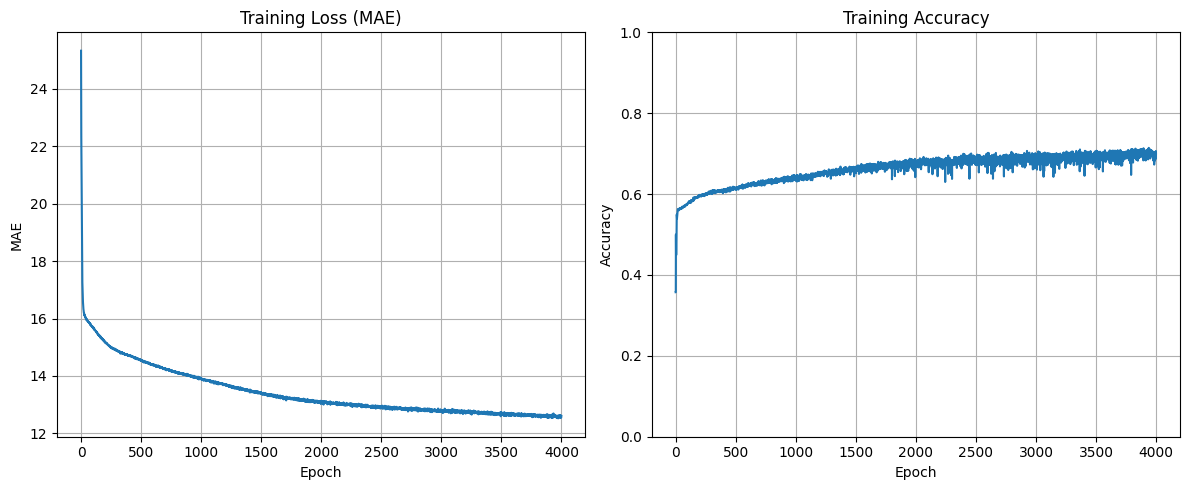

In [598]:
weightedFFNN.plot_training_history()

По метрикам вижно, что 0 ранг предсказывает заметно точнее, чем два остальных

In [600]:
y_pred_weighted_ffnn = weightedFFNN.predict(X_test)
print("\n \n Test Data: Confusion Matrix: \n ")
print(confusion_matrix(y_test, y_pred_weighted_ffnn))

print("\n Test Data: Classification Report:\n ")
print(classification_report(y_test, y_pred_weighted_ffnn))


 
 Test Data: Confusion Matrix: 
 
[[420 211  17]
 [186 471 160]
 [ 15 128 206]]

 Test Data: Classification Report:
 
              precision    recall  f1-score   support

           0       0.68      0.65      0.66       648
           1       0.58      0.58      0.58       817
           2       0.54      0.59      0.56       349

    accuracy                           0.60      1814
   macro avg       0.60      0.60      0.60      1814
weighted avg       0.61      0.60      0.61      1814



R^2 помогает понять какой процент variance объясняет модель, и обычно используется в задачах, где целевая переменная непрерывная. У нас же она порядковая. У меня целеая переменная закодирована как ранги (0 1 2) с одинаковыми расстояними, поэтому в нашем случае MAE будет эквивалентен MARE, где вычитыаемые значения заменяются рангами. В нашем случае MAE получается близким к 0.41, что означает в среднем ваша модель ошибается на 0.41 балл

In [640]:
test_r2           = weightedFFNN.score(X_test, y_test)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_weighted_ffnn)
test_r2

y_pred_cont_weighted_ffnn = weightedFFNN.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_cont_weighted_ffnn)


print(f'R^2: {test_r2}')
print(f'MAE: {test_mae}')
print(f'Accuracy (balanced): {balanced_accuracy}')

R^2: 0.2703025919242671
MAE: 0.41289966923925026
Accuracy (balanced): 0.6049684719364016


Построим ROC кривые для каждого класса, подбирая лучший порог разделения для определения класса. Можно заметить, что получился хороший AUC 0.734, что говорит о правильности предсказания более 70% процентов вин. Значит, скорее всего, можно подобрать оптимальный порог под класс во время обучения, что значительно бы улучшило и другие метрики. Также модель могла бы улучшиться за счет внедрения Loss функции специфичной для порядковой регрессии

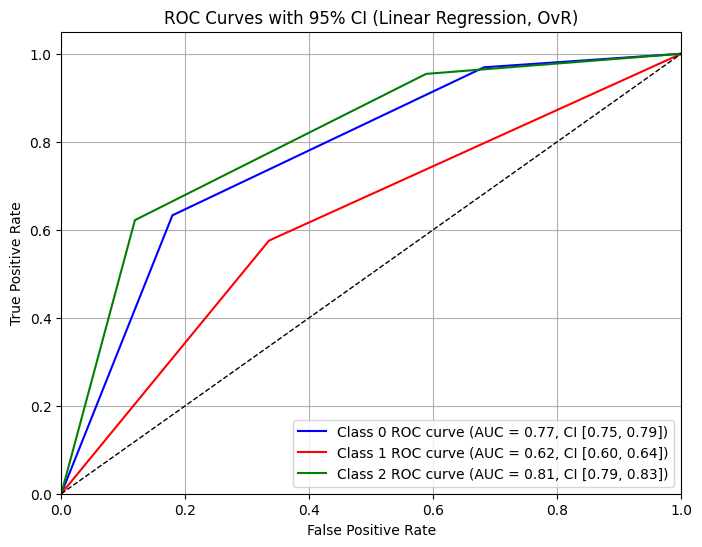

Macro-average ROC AUC (OvR): 0.734


In [635]:
def bootstrap_roc_auc_ci(y_true, y_score, n_bootstraps=1000, ci=0.95, random_seed=42):
    rng = np.random.RandomState(random_seed)
    bootstrapped_rocs = []
    n_samples = len(y_true)

    for _ in range(n_bootstraps):
        indices = rng.randint(0, n_samples, n_samples)
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = auc(*roc_curve(y_true[indices], y_score[indices])[:2])
        bootstrapped_rocs.append(score)

    sorted_scores = np.array(bootstrapped_rocs)
    sorted_scores.sort()
    lower_bound = sorted_scores[int((1 - ci) / 2 * len(sorted_scores))]
    upper_bound = sorted_scores[int((1 + ci) / 2 * len(sorted_scores))]
    return lower_bound, upper_bound


y_scores = y_pred_cont_weighted_ffnn 
y_test_bin = label_binarize(y_test, classes=[0,1,2])
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']

for i, color in zip(range(n_classes), colors):
    class_scores = -np.abs(y_scores - i)
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], class_scores)
    roc_auc = auc(fpr, tpr)
    ci_lower, ci_upper = bootstrap_roc_auc_ci(y_test_bin[:, i], class_scores)
    plt.plot(fpr, tpr, color=color,
             label=f'Class {i} ROC curve (AUC = {roc_auc:.2f}, CI [{ci_lower:.2f}, {ci_upper:.2f}])')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves with 95% CI (Linear Regression, OvR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# OVR AUC
macro_roc_auc_ovr = roc_auc_score(y_test_bin, 
                                  np.vstack([-np.abs(y_scores - i) for i in range(n_classes)]).T,
                                  average="macro", multi_class="ovr")
print(f"Macro-average ROC AUC (OvR): {macro_roc_auc_ovr:.3f}")


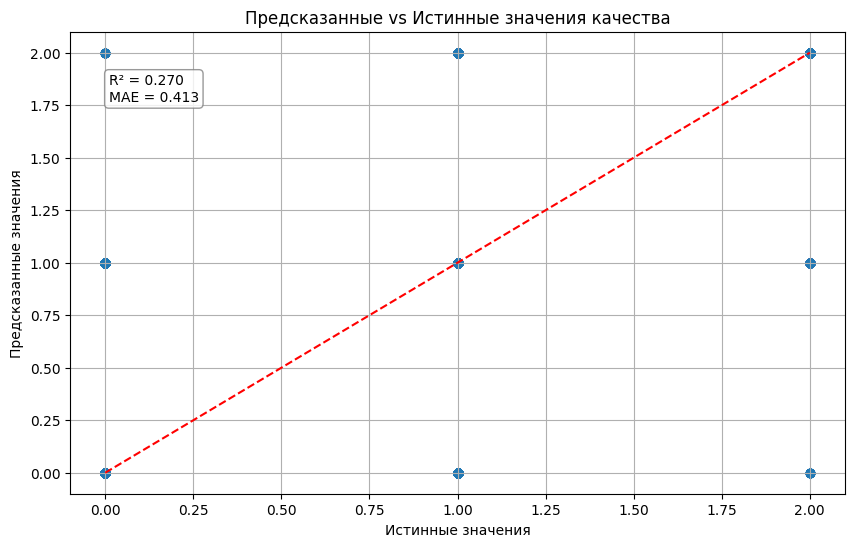

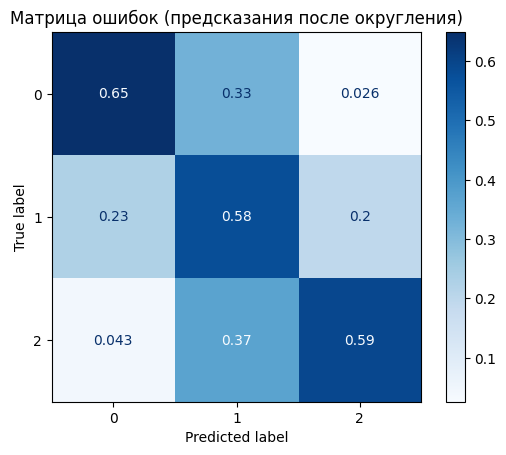

In [666]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_weighted_ffnn, alpha=0.6)
plt.plot([0, 2], [0, 2], 'r--')
plt.title('Предсказанные vs Истинные значения качества')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.grid(True)
plt.annotate(f'R² = {test_r2:.3f}\nMAE = {test_mae:.3f}', 
             xy=(0.05, 0.85), xycoords='axes fraction',
             bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.8))
plt.savefig('predictions_vs_actuals.png')
plt.show()

disp = ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_weighted_ffnn, 
    normalize='true',  
    display_labels=sorted(y_test.unique()),
    cmap='Blues'
)
plt.title('Матрица ошибок (предсказания после округления)')
plt.savefig('confusion_matrix.png')
plt.show()


По распределению остатков видно, что большинство рангов предсказано правильно и большинство ошибок всего лишь на 1 ранг

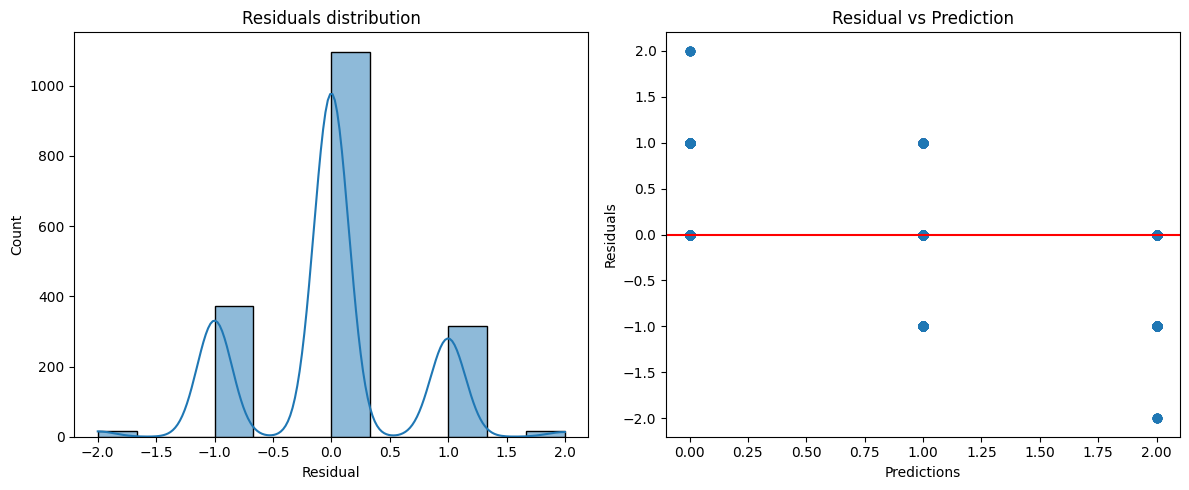

In [656]:
residuals = y_test - y_pred_weighted_ffnn
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Residuals distribution')
plt.xlabel('Residual')

plt.subplot(1, 2, 2)
plt.scatter(y_pred_weighted_ffnn, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual vs Prediction')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.tight_layout()
plt.savefig('residuals_analysis.png')
plt.show()

## KNN

В качестве модели для сравнения я выбрал KNNClassifier, можно заметить, что по всем метрика он получается заметно лучше, но с другой стороны, это уже готовый отвалидированный алгоритм внутри scikit-learn. Однако, я считаю, что для такого рода задачи модели градиентного бустинга заточенные под ordinal regression подолшли бы лучше, так как учитывают порядковую природу данных. Также тот же XGBoost учитывает взаимодействие признаков и устойчивее к выбросам. Нейросети для такого малого количества данных могут оказаться сложной моделью, чем проще модель тем меньше шанс overfitting.

In [488]:
k_range = range(1, 31)
nn_range = list(range(1, 31))
print(f"nn_range: {k_range}")
param_grid = dict(n_neighbors=nn_range)
print(f"param_grid = {param_grid}\n")

grid = GridSearchCV(KNeighborsClassifier(n_neighbors=5, weights='distance'), 
                    param_grid, 
                    cv=10, 
                    scoring='balanced_accuracy', 
                    return_train_score=False)
grid.fit(X_train, y_train)

nn_range: range(1, 31)
param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}



GridSearchCV(cv=10, estimator=KNeighborsClassifier(weights='distance'),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='balanced_accuracy')

In [489]:
grid.best_params_

{'n_neighbors': 28}

In [646]:
KNN_Model = KNeighborsClassifier(n_neighbors=28, weights='distance')
KNN_Model.fit(X_train, y_train)
y_score_knn = KNN_Model.predict_proba(X_test)
KNN_test_predictions = KNN_Model.predict(X_test)

In [647]:
print("\n \n Test Data: KNN_Confusion Matrix: \n ")
print(confusion_matrix(y_test, KNN_test_predictions))

print("\n Test Data: KNN_Classification Report:\n ")
print(classification_report(y_test, KNN_test_predictions))


 
 Test Data: KNN_Confusion Matrix: 
 
[[450 187  11]
 [128 608  81]
 [ 14 124 211]]

 Test Data: KNN_Classification Report:
 
              precision    recall  f1-score   support

           0       0.76      0.69      0.73       648
           1       0.66      0.74      0.70       817
           2       0.70      0.60      0.65       349

    accuracy                           0.70      1814
   macro avg       0.71      0.68      0.69      1814
weighted avg       0.70      0.70      0.70      1814



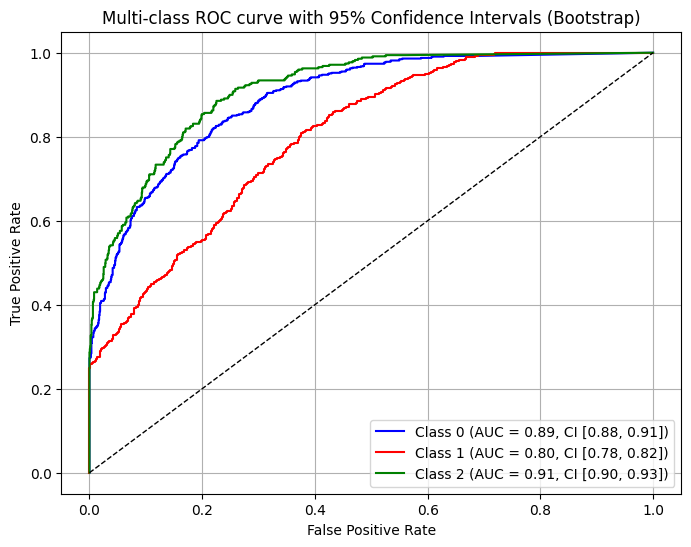

Macro-average ROC AUC (OvR): 0.868


In [636]:
y_test_proba = label_binarize(y_test, classes=[0, 1, 2])
n_classes = 3

y_score = y_score_knn
y_score = np.vstack([prob[:,1] for prob in y_score]).T if isinstance(y_score, list) else y_score

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_proba[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

def bootstrap_auc(y_true, y_score, n_bootstraps=1000, random_seed=42):
    rng = np.random.RandomState(random_seed)
    bootstrapped_scores = []
    n_samples = y_true.shape[0]
    for _ in range(n_bootstraps):
        indices = rng.randint(0, n_samples, n_samples)
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = auc(*roc_curve(y_true[indices], y_score[indices])[:2])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    lower = sorted_scores[int(0.025 * len(sorted_scores))]
    upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return lower, upper

ci = dict()
for i in range(n_classes):
    ci[i] = bootstrap_auc(y_test_proba[:, i], y_score[:, i])

colors = ['blue', 'red', 'green']
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='Class {0} (AUC = {1:0.2f}, CI [{2:0.2f}, {3:0.2f}])'
                   ''.format(i, roc_auc[i], ci[i][0], ci[i][1]))
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curve with 95% Confidence Intervals (Bootstrap)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

macro_roc_auc_ovr = roc_auc_score(y_test_proba, 
                                  y_score,
                                  average="macro", multi_class="ovr")
print(f"Macro-average ROC AUC (OvR): {macro_roc_auc_ovr:.3f}")


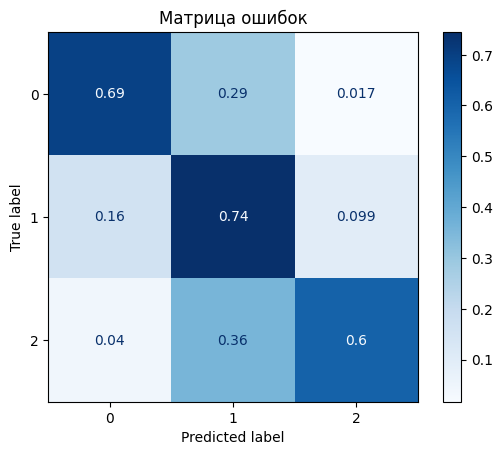

In [667]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, 
    KNN_test_predictions, 
    normalize='true',
    display_labels=sorted(y_test.unique()),
    cmap='Blues'
)
plt.title('Матрица ошибок')
plt.savefig('confusion_matrix.png')
plt.show()

## MLPClassifier

Я попробовал применить такжей простейшую нейронную сеть Classifier, но она недопредсказывает 2 ранг. 

In [605]:
pipeline = Pipeline([
    ('model', MLPClassifier(
        hidden_layer_sizes=(8),
        activation='relu',
        solver='adam',
        early_stopping=True,
        random_state=42
    ))
])

param_grid = {
    'model__hidden_layer_sizes': [(16,), (16, 32), (8, 16)],
    'model__alpha': [0.0001, 0.001, 0.01], 
    'model__learning_rate_init': [0.001, 0.0005],
    'model__batch_size': [32, 64]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=3,
    n_jobs=-1,
    verbose=3
)

grid.fit(X_train, y_train)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 3/3] END model__alpha=0.0001, model__batch_size=32, model__hidden_layer_sizes=(16,), model__learning_rate_init=0.001;, score=0.518 total time=   0.4s
[CV 2/3] END model__alpha=0.0001, model__batch_size=32, model__hidden_layer_sizes=(16,), model__learning_rate_init=0.001;, score=0.523 total time=   0.4s
[CV 1/3] END model__alpha=0.0001, model__batch_size=32, model__hidden_layer_sizes=(16,), model__learning_rate_init=0.001;, score=0.518 total time=   0.5s
[CV 1/3] END model__alpha=0.0001, model__batch_size=32, model__hidden_layer_sizes=(16,), model__learning_rate_init=0.0005;, score=0.521 total time=   0.5s
[CV 2/3] END model__alpha=0.0001, model__batch_size=32, model__hidden_layer_sizes=(16,), model__learning_rate_init=0.0005;, score=0.513 total time=   0.8s
[CV 1/3] END model__alpha=0.0001, model__batch_size=32, model__hidden_layer_sizes=(16, 32), model__learning_rate_init=0.001;, score=0.548 total time=   0.7s
[CV 3/3] 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('model',
                                        MLPClassifier(early_stopping=True,
                                                      hidden_layer_sizes=8,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.0001, 0.001, 0.01],
                         'model__batch_size': [32, 64],
                         'model__hidden_layer_sizes': [(16,), (16, 32),
                                                       (8, 16)],
                         'model__learning_rate_init': [0.001, 0.0005]},
             scoring='balanced_accuracy', verbose=3)

In [606]:
y_pred = grid.best_estimator_.predict(X_test)

In [ ]:
pipeline = Pipeline([
    ('model', MLPClassifier(
        hidden_layer_sizes=(8),
        activation='relu',
        solver='adam',
        early_stopping=True,
        random_state=42
    ))
])

param_grid = {
    'model__hidden_layer_sizes': [(16,), (16, 32), (8, 16)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.0005],
    'model__batch_size': [32, 64]
}

{'model__alpha': 0.0001,
 'model__batch_size': 64,
 'model__hidden_layer_sizes': (16, 32),
 'model__learning_rate_init': 0.001}

In [610]:
mlpClassifier = MLPClassifier(alpha=grid.best_params_['model__alpha'],
              batch_size=grid.best_params_['model__batch_size'],
              hidden_layer_sizes=grid.best_params_['model__hidden_layer_sizes'],
              learning_rate_init=grid.best_params_['model__learning_rate_init'],
              activation='relu',
              solver='adam',
              early_stopping=True,
              random_state=42)
mlpClassifier.fit(X_train, y_train)

MLPClassifier(batch_size=64, early_stopping=True, hidden_layer_sizes=(16, 32),
              random_state=42)

In [611]:
y_pred_mlpClassifier = mlpClassifier.predict(X_test)

In [612]:
balanced_accuracy_score(y_test, y_pred_mlpClassifier)

np.float64(0.5321279821780952)

In [614]:
print("\n \n Test Data: MLP Classifier Matrix: \n ")
print(confusion_matrix(y_test, y_pred))

print("\n Test Data: MLP Classifier Report:\n ")
print(classification_report(y_test, y_pred))


 
 Test Data: MLP Classifier Matrix: 
 
[[386 259   3]
 [193 539  85]
 [ 18 212 119]]

 Test Data: MLP Classifier Report:
 
              precision    recall  f1-score   support

           0       0.65      0.60      0.62       648
           1       0.53      0.66      0.59       817
           2       0.57      0.34      0.43       349

    accuracy                           0.58      1814
   macro avg       0.59      0.53      0.55      1814
weighted avg       0.58      0.58      0.57      1814



In [367]:
r2_score(y_test, grid.best_estimator_.predict(X_test))

0.13792748422628054

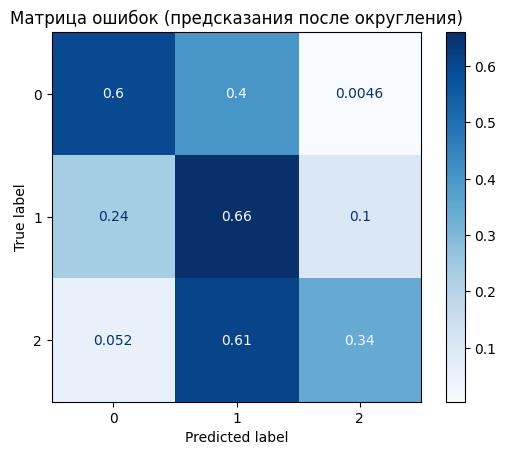

In [664]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_mlpClassifier, 
    normalize='true',
    display_labels=sorted(y_test.unique()),
    cmap='Blues'
)
plt.title('Матрица ошибок (предсказания после округления)')
plt.savefig('confusion_matrix.png')
plt.show()